In [25]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes
import warnings
import ot
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "blue", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "red"]

In [32]:
def data_scaled(N, m, scale, seed):
    np.random.seed(seed)
    R = np.vstack([np.random.normal(
    0.1 + i*0.05*scale, np.sqrt((0.02**2+(i*0.1)**2)), N) for i in range(1, m+1)])
    return (R.transpose())

# def data_scaled(N, m, scale, seed):
#     np.random.seed(seed)
#     R = np.vstack([np.random.normal(
#     i*0.03*scale, np.sqrt((0.02**2+(i*0.025)**2)), N) for i in range(1, m+1)])
#     return (R.transpose())

def data_modes(N, m, scales, seed):
    modes = len(scales)
    d = np.zeros((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights,
          :] = data_scaled(weights, m, scales[i], seed)
    return d[0:N, :]

m = 30
data = data_modes(600,m,[1,2,3,4,5],seed = 15)
scenarios = {}
num_scenarios = 5
for scene in range(num_scenarios):
    np.random.seed(scene)
    scenarios[scene] = {}
    scenarios[scene][0] = 8 + scene*0.5

In [33]:
def loss(y,tau,x,p,alpha, data,l=10000,quantile = 0.95, target = -0.1):
    sums = 0
    totsum = 0
    Nsample = data.shape[0]
    sums += torch.sum(torch.maximum(torch.maximum(-data@x + p*tau - y- alpha,(-1-5*p)*data@x - 4*p*tau - y- alpha),torch.tensor(0.,requires_grad = True)))
    totsum += torch.sum(torch.where(torch.maximum(torch.maximum(-data@x + p*tau - y- alpha,(-1-5*p)*data@x - 4*p*tau - y- alpha),torch.tensor(0.,requires_grad = True))>= 0.001,torch.tensor(1.), torch.tensor(0.)))
    sums = (sums/((1-quantile)*Nsample)) + alpha
    return y + torch.tensor(l)*(sums - torch.tensor(target)), torch.mean(-data@x)+p*torch.mean(tau + 5*torch.maximum(-data@x-tau,torch.tensor(0))), totsum/Nsample, sums.detach().numpy()


In [34]:
data = data_modes(600,m,[1,2,3,4,5],seed = 2)
u = lropt.UncertainParameter(m,
                        uncertainty_set=lropt.Ellipsoidal(p=2,
                                                    data=data, loss = loss))
# Formulate the Robust Problem
x = cp.Variable(m)
tau = cp.Variable()
y = cp.Variable()
p = cp.Parameter()
p.value = scenarios[0][0]
objective = cp.Minimize(y)
constraints = [p >= 0]
constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
constraints += [cp.sum(x)==1, x >= 0]
prob = lropt.RobustProblem(objective, constraints)

target = -0.05
test_p = 0.5
s = 5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init = np.eye(m)
init_bval = -init@np.mean(train, axis=0)
# Train A and b
result1 = prob.train(lr = 0.00001, step=200, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False,init_lam = 0.5, target_cvar = target, init_alpha = 0., test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.00001,batch_percentage = 0.8)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

In [35]:
# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.1, 20, 100), init_A = np.eye(m), init_b = -np.mean(train, axis=0), seed = s, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

result5 = prob.grid(epslst = np.linspace(0.1,20, 100), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0., test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

In [36]:
def plot_coverage_all(df_standard,df_reshape,dfs,title,ind_1 = (0,100), ind_2 = (0,100), logscale = True, legend = False, zoom = False):
    plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
    beg1,end1 = ind_1
    beg2,end2 = ind_2

    fig, (ax, ax1,ax2) = plt.subplots(1, 3, figsize=(23, 3))
    
    ax.plot(np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
    ax.fill(np.append(np.quantile(np.vstack(df_standard['Violations']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Violations']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.9,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax.plot(np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set")
    ax.fill(np.append(np.quantile(np.vstack(df_reshape['Violations']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Violations']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.9,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    ax.set_xlabel("Probability of constraint violation")
    ax.axvline(x = 0.03, color = "green", linestyle = "-.",label = r"$\eta = 0.03$")
    ax.set_title("Objective value")
    ax.set_ylabel("$m = 30$", fontsize = 25)
    # ax.set_yticks(ticks = [-2e1,0,2e1])
    # ax.set_yticks(ticks = [-1,0,1])
    ax.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax.legend()

    ax1.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Test_val']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")
    ax1.fill(np.append(np.quantile(np.vstack(df_standard['coverage_test']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['coverage_test']),0.9,axis = 1)[beg1:end1][::-1]), np.append(np.quantile(np.vstack(df_standard['Test_val']),0.1,axis = 1)[beg1:end1],np.quantile(np.vstack(df_standard['Test_val']),0.90,axis = 1)[beg1:end1][::-1]), color="tab:blue", alpha=0.2)

    ax1.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(df_reshape['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",label=r"Decision-Focused set")
    ax1.fill(np.append(np.quantile(np.vstack(df_reshape['coverage_test']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['coverage_test']),0.9,axis = 1)[beg2:end2][::-1]), np.append(np.quantile(np.vstack(df_reshape['Test_val']),0.1,axis = 1)[beg2:end2],np.quantile(np.vstack(df_reshape['Test_val']),0.90,axis = 1)[beg2:end2][::-1]), color="tab:orange", alpha=0.2)
    if dfs:
        for i in range(5):
            ax1.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Test_val']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax1.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Test_val']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")

    ax1.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    ax1.axvline(x = 0.8, color = "black", linestyle = ":",label = "0.8 Coverage")

    if logscale:
        ax1.set_xscale("log")
    # ax1.set_yticks(ticks = [-1,0,1])

    ax1.set_xlabel("Test set coverage")
    ax1.set_title("Objective value")
    # ax1.legend()

    ax2.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue", label=r"Mean-Var set")

    ax2.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange", label=r"Reshaped set",alpha = 0.8)
    if dfs:
        for i in range(5):
            ax2.plot(np.mean(np.vstack(dfs[i+1][0]['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(dfs[i+1][0]['Violations']),axis = 1)[beg1:end1], color="tab:blue", linestyle = "-")
            ax2.plot(np.mean(np.vstack(dfs[i+1][1]['coverage_test']),axis = 1)[beg2:end2],np.mean(np.vstack(dfs[i+1][1]['Violations']),axis = 1)[beg2:end2], color = "tab:orange",linestyle = "-")
    # ax2.plot(np.arange(100)/100, 1 - np.arange(100)/100, color = "red")
    # ax2.set_ylim([-0.05,0.25])
    ax2.axvline(x = 0.8, color = "black",linestyle = ":", label = "0.8 Coverage")
    ax2.axhline(y = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
    ax2.set_title("Probility of constraint violation")
    ax2.set_xlabel("Test set coverage")
    if zoom:
        axins = zoomed_inset_axes(ax2, 6, loc="upper center")
        axins.set_xlim(-0.005, 0.1)
        axins.set_ylim(-0.001,0.035)
        axins.plot(np.mean(np.vstack(df_standard['coverage_test']),axis = 1)[beg1:end1], np.mean(np.vstack(df_standard['Violations']),axis = 1)[beg1:end1], color="tab:blue")
        axins.plot(np.mean(np.vstack(df_reshape['coverage_test']),axis = 1)[beg2:end2], np.mean(np.vstack(df_reshape['Violations']),axis = 1)[beg2:end2], color="tab:orange",alpha = 0.8)
        axins.axhline(y = 0.03, color = "green",linestyle = "-.", label = r"$\hat{\eta} = 0.03$")
        axins.set_xticks(ticks=[])
        axins.set_yticks(ticks=[])
        mark_inset(ax2, axins, loc1=3, loc2=4, fc="none", ec="0.5")
    if logscale:
        ax2.set_xscale("log")
    # ax2.ticklabel_format(style="sci",axis='y',scilimits = (0,0), useMathText=True)
    # ax2.legend()
    if legend:
        ax2.legend(bbox_to_anchor=(-1.8, -0.6, 0, 0), loc="lower left",
                 borderaxespad=0, ncol=4, fontsize = 24)
    # lines_labels = [ax.get_legend_handles_labels()]
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels,loc='upper center', ncol=2,bbox_to_anchor=(0.5, 1.2))
    plt.subplots_adjust(left=0.1)
    plt.savefig(title+"_curves.pdf",bbox_inches='tight')
    plt.show()

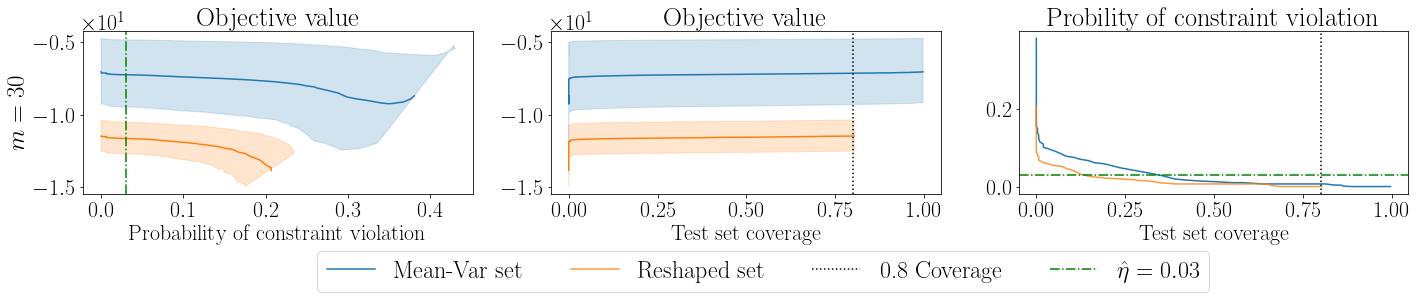

In [37]:
plot_coverage_all(dfgrid,dfgrid2,None, "Port",ind_1=(3,400),ind_2=(3,400), logscale = False, legend = True)

In [261]:
result4 = prob.grid(epslst = np.linspace(10, 11, 30), init_A = init, init_b = init_bval, seed = s, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

result5 = prob.grid(epslst = np.linspace(9.5,10.5,30), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0., test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

In [209]:
reshaped_cvar, x_re = cvar_table(A_fin, b_fin, dfgrid2,test,train,0.012, eps = 0)
standard_cvar, x_st = cvar_table(init, init_bval, dfgrid,test,train,0.03, eps = 0)

In [200]:
make_table(A_fin, b_fin, dfgrid2,test,train,0.025, eps = 0)

array([[-8.29284105e+00,  2.99999993e-02,  6.33333325e-02,
         0.00000000e+00,  6.66666667e-03,  2.59358300e-03],
       [-8.68624902e+00,  2.99999993e-02,  6.33333325e-02,
         0.00000000e+00,  6.66666667e-03,  4.24608400e-03],
       [-9.07965886e+00,  2.99999993e-02,  6.33333325e-02,
         0.00000000e+00,  6.66666667e-03,  2.47833400e-03],
       [-9.47311071e+00,  2.99999993e-02,  6.33333325e-02,
         0.00000000e+00,  6.66666667e-03,  4.29858300e-03],
       [-9.86661957e+00,  2.99999993e-02,  6.33333325e-02,
         0.00000000e+00,  6.66666667e-03,  2.34012500e-03]])

In [201]:
make_table(init, init_bval, dfgrid,test,train,0.025, eps = 0)

array([[-4.51515688e+00,  2.99999993e-02,  6.33333325e-02,
         1.66666667e-02,  2.00000000e-02,  7.84541000e-04],
       [-4.68309224e+00,  2.99999993e-02,  6.33333325e-02,
         1.66666667e-02,  2.00000000e-02,  7.97125000e-04],
       [-4.85111570e+00,  2.99999993e-02,  6.33333325e-02,
         1.66666667e-02,  2.00000000e-02,  7.81333000e-04],
       [-5.01922004e+00,  2.99999993e-02,  6.33333325e-02,
         1.66666667e-02,  2.00000000e-02,  1.02287500e-03],
       [-5.18734507e+00,  2.99999993e-02,  6.33333325e-02,
         1.66666667e-02,  2.00000000e-02,  7.06833000e-04]])

In [170]:
dfgrid['Eps'][np.absolute(np.mean(np.vstack(dfgrid['Violations']),axis = 1)-0.03).argmin()]

6.316633266533066

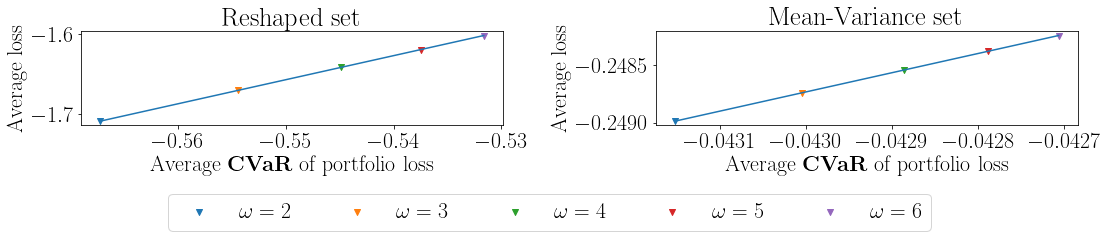

In [211]:
plt.rcParams.update({
    "text.usetex":True,

    "font.size":22,
    "font.family": "serif"
})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 3))
ax1.plot(reshaped_cvar[:,1], reshaped_cvar[:,0])
for scene in range(num_scenarios):
    ax1.scatter(reshaped_cvar[scene][1], reshaped_cvar[scene][0], marker = "v", label = r'$\omega = {}$'.format(scene+2))
ax1.set_title("Reshaped set")
ax1.set_ylabel("Average loss")
ax1.set_xlabel(r"Average $\textbf{CVaR}$ of portfolio loss")
fig.legend(bbox_to_anchor=(0.5,-0.06,0,0), loc="center",
                 borderaxespad=0, ncol=5)
ax2.plot(standard_cvar[:,1], standard_cvar[:,0])
for scene in range(num_scenarios):
    ax2.scatter(standard_cvar[scene][1], standard_cvar[scene][0], marker = "v")
ax2.set_ylabel("Average loss")
ax2.set_title("Mean-Variance set")
ax2.set_xlabel(r"Average $\textbf{CVaR}$ of portfolio loss")
plt.tight_layout()
plt.savefig("port_cvar_curves.pdf",bbox_inches='tight')
plt.show()

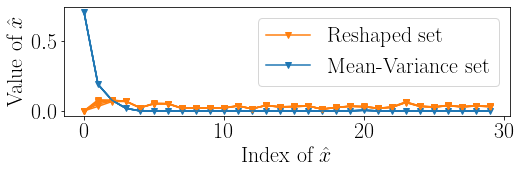

In [212]:
plt.figure(figsize=(8, 2))
plt.plot(x_re[0], color = "tab:orange", label = "Reshaped set", marker = "v")
plt.plot(x_st[0], color = "tab:blue",label = "Mean-Variance set", marker = "v")
for scene in range(1,5):
  plt.plot(x_re[scene], color = "tab:orange", marker = "v")
  plt.plot(x_st[scene], color = "tab:blue")
plt.ylabel("Value of $\hat{x}$")
plt.xlabel("Index of $\hat{x}$")
plt.legend()
plt.savefig("port_xvals.pdf", bbox_inches='tight')
plt.show()

In [263]:

def eval(y,tau,x,p,data,l=10000,quantile = 0.95, target = -0.1):
    y = torch.tensor(y)
    tau = torch.tensor(tau)
    x = torch.tensor(x)
    p = torch.tensor(p)
    data = torch.tensor(data)
    Nsample = data.shape[0]
    totsum = torch.sum(torch.where(torch.maximum(torch.maximum(-data@x + p*tau - y,(-1-5*p)*data@x - 4*p*tau - y),torch.tensor(0.,requires_grad = True))>= 0.001,torch.tensor(1.), torch.tensor(0.)))/Nsample
    return totsum


def ret_cvar(y,tau,x,p,data):
    y = torch.tensor(y)
    tau = torch.tensor(tau)
    x = torch.tensor(x)
    p = torch.tensor(p)
    data = torch.tensor(data)    
    return torch.mean(-data@x), torch.mean(tau + 5*torch.maximum(-data@x-tau,torch.tensor(0)))

def cvar_table(result_A,result_b, dfgrid,test, train, value,eps):
    trial1 = np.zeros((num_scenarios,2))
    xvals = np.zeros((num_scenarios,m))
    for scene in range(num_scenarios):
        # formulate the ellipsoidal set
        if eps:
          r_eps = 1
        else:
          r_eps = dfgrid['Eps'][np.absolute(np.mean(np.vstack(dfgrid['Violations_train']),axis = 1)-value).argmin()]
        u = lropt.UncertainParameter(m,
                                    uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                    rho=1., A = (1/r_eps)*result_A, b=(1/r_eps)*result_b))    
        # Formulate the Robust Problem
        x = cp.Variable(m)
        tau = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter()
        p.value = scenarios[scene][0]
        objective = cp.Minimize(y)
        constraints = [p >= 0]
        constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
        constraints += [cp.sum(x)==1, x >= 0]
        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        ret, cvar = ret_cvar(y.value,tau.value,x.value,p.value,test)
        trial1[scene,0] = ret.item()
        trial1[scene,1] = cvar.item()
        xvals[scene] = x.value
    return trial1, xvals

def make_table(result_A,result_b, dfgrid,test, train, value,eps):
    trial1 = np.zeros((num_scenarios,6))
    for scene in range(num_scenarios):
        # formulate the ellipsoidal set
        if eps:
          r_eps = 1
        else:
          r_eps = dfgrid['Eps'][np.absolute(np.mean(np.vstack(dfgrid['Violations']),axis = 1)-value).argmin()]
        u = lropt.UncertainParameter(m,
                                    uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                    rho=1., A = (1/r_eps)*result_A, b=(1/r_eps)*result_b))    
        # Formulate the Robust Problem
        x = cp.Variable(m)
        tau = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter()
        p.value = scenarios[scene][0]
        objective = cp.Minimize(y)
        constraints = [p >= 0]
        constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
        constraints += [cp.sum(x)==1, x >= 0]
        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()

        coverage = 0
        for datind in range(test.shape[0]):
            coverage += np.where(np.linalg.norm((1/r_eps)*result_A@test[datind] + (1/r_eps)*result_b)<= 1, 1, 0 )
        coverage_train = 0
        for datind in range(train.shape[0]):
            coverage_train += np.where(np.linalg.norm((1/r_eps)*result_A@train[datind] + (1/r_eps)*result_b)<= 1, 1, 0 )

        trial1[scene,0] = np.mean(-test@x.value)+ p.value*np.mean(tau.value + 5*np.maximum(-test@x.value-tau.value,0))
        trial1[scene,1] = eval(y.value,tau.value,x.value,p.value,test).item()
        trial1[scene,2] = eval(y.value,tau.value,x.value,p.value,train).item()
        trial1[scene,3] = coverage/test.shape[0]
        trial1[scene,4] = coverage_train/train.shape[0]
        trial1[scene,5] = newprob.solver_stats.solve_time
        # trial1[scene,6] = np.linalg.det(sc.linalg.inv((1/r_eps)*result_A@((1/r_eps)*result_A)))**0.5
    return trial1
def mro(train, test, K = 300, rho = 1):
    vios = np.zeros((num_scenarios))
    vios_1 = np.zeros((num_scenarios))
    objs = np.zeros((num_scenarios))
    time = np.zeros((num_scenarios))
    for scene in range(num_scenarios):
        u = lropt.UncertainParameter(m,
                                          uncertainty_set = lropt.MRO(train = False, data = train, rho = rho, A = None, K = K))
            # Formulate the Robust Problem
        x = cp.Variable(m)
        tau = cp.Variable()
        y = cp.Variable()
        p = cp.Parameter()
        p.value = scenarios[scene][0]
        objective = cp.Minimize(y)
        constraints = [p >= 0]
        constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
        constraints += [cp.sum(x)==1, x >= 0]
        prob = lropt.RobustProblem(objective, constraints)
        newprob = prob.dualize_constraints()
        newprob.solve()
        objs[scene] = np.mean(-test@x.value)+ p.value*np.mean(tau.value + 5*np.maximum(-test@x.value-tau.value,0))
        vios[scene] = eval(y.value,tau.value,x.value,p.value,test).item()
        vios_1[scene] = eval(y.value,tau.value,x.value,p.value,train).item()
        time[scene] = newprob.solver_stats.solve_time
    return vios, vios_1, objs, time

In [282]:
Ar_saved = np.zeros((100,m,m))
br_saved = np.zeros((100,m))
# As_saved = np.zeros((100,15,15))
# bs_saved = np.zeros((100,15))
reshaped_table = np.zeros((1,18))
standard_table = np.zeros((1,18))
for experiment in range(20):
    np.random.seed(experiment)
    data = data_modes(600,m,[1,2,3,4,5],seed = experiment)
    # Formulate uncertainty set
    u = lropt.UncertainParameter(m,
                            uncertainty_set=lropt.Ellipsoidal(p=2,
                                                        data=data, loss = loss))
    # Formulate the Robust Problem
    x = cp.Variable(m)
    tau = cp.Variable()
    y = cp.Variable()
    p = cp.Parameter()
    p.value = scenarios[0][0]
    objective = cp.Minimize(y)
    constraints = [p >= 0]
    constraints += [cp.maximum(p*tau + -x@u, - 4*p*tau + (-1-5*p)*x@u ) <= y]
    constraints += [cp.sum(x)==1, x >= 0]
    prob = lropt.RobustProblem(objective, constraints)

    target = -0.05
    test_p = 0.5
    s = 5
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
    init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
    init = np.eye(m)
    init_bval = -init@np.mean(train, axis=0)
    # Train A and b
    # result1 = prob.train(lr = 0.001, step=200, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False,init_lam = 0.5, target_cvar = target, init_alpha = 0., test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.1,batch_percentage = 0.8)
    result1 = prob.train(lr = 0.00001, step=200, momentum = 0.8, optimizer = "SGD", seed = s, init_A = init, init_b = init_bval, fixb = False,init_lam = 0.5, target_cvar = target, init_alpha = 0., test_percentage = test_p, scenarios = scenarios, num_scenarios = num_scenarios, step_y = 0.00001,batch_percentage = 0.8)
    df1 = result1.df
    A_fin = result1.A
    b_fin = result1.b
    Ar_saved[experiment,:] = A_fin
    br_saved[experiment,:] = b_fin

    # Grid search epsilon
    result4 = prob.grid(epslst = np.linspace(10, 11, 200), init_A = init, init_b = init_bval, seed = s, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid = result4.df

    result5 = prob.grid(epslst = np.linspace(9.5,12.5,200), init_A = A_fin, init_b = b_fin, seed = s, init_alpha = 0., test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
    dfgrid2 = result5.df

    r_t = make_table(A_fin, b_fin, dfgrid2,test,train,0.024, eps = 0)
    r_t1 = make_table(A_fin, b_fin, dfgrid2,test,train,0.01, eps = 0)
    r_t2 = make_table(A_fin, b_fin, dfgrid2,test,train,0.0001, eps = 0)
    r_t = np.hstack((r_t, r_t1, r_t2))
    
    reshaped_table = np.vstack((reshaped_table, r_t))

    s_t = make_table(init, init_bval, dfgrid,test, train,0.024, eps = 0)
    s_t1 = make_table(init, init_bval, dfgrid,test, train,0.20, eps = 0)
    s_t2 = make_table(init, init_bval, dfgrid,test, train,0.022, eps = 0)
    s_t = np.hstack((s_t, s_t1, s_t2))
    standard_table = np.vstack((standard_table, s_t))
    # pd.DataFrame(standard_table).to_csv("standard_table30.csv")
    # pd.DataFrame(reshaped_table).to_csv("reshaped_table30.csv")
    np.save("Ar_saved.npy", Ar_saved)
    # np.save("As_saved.npy", As_saved)
    np.save("br_saved.npy", br_saved)
    # np.save("bs_saved.npy", bs_saved)
    print("standard", s_t)
    print("reshaped", r_t)
# standard_table = pd.read_csv("standard_table_1.csv").iloc[:,1:]
# reshaped_table = pd.read_csv("reshaped_table_1.csv").iloc[:,1:]
# standard_table = standard_table.values
# reshaped_table = reshaped_table.values
# pd.DataFrame(standard_table).to_csv("standard_table_1.csv")
# pd.DataFrame(reshaped_table).to_csv("reshaped_table_1.csv")
reshaped_table = reshaped_table[1:]
standard_table = standard_table[1:]

standard [[-3.94251321e+00  2.66666673e-02  4.33333330e-02  4.93333333e-01
   4.23333333e-01  8.18958000e-04 -3.95862820e+00  5.33333346e-02
   6.66666701e-02  3.30000000e-01  2.70000000e-01  7.78083000e-04
  -3.94213134e+00  2.66666673e-02  4.33333330e-02  4.93333333e-01
   4.23333333e-01  7.86750000e-04]
 [-4.02504002e+00  2.66666673e-02  4.33333330e-02  4.93333333e-01
   4.23333333e-01  8.75625000e-04 -4.04096908e+00  5.33333346e-02
   6.66666701e-02  3.30000000e-01  2.70000000e-01  7.65792000e-04
  -4.02467567e+00  2.66666673e-02  4.33333330e-02  4.93333333e-01
   4.23333333e-01  1.08575000e-03]
 [-4.10767061e+00  2.66666673e-02  4.33333330e-02  4.93333333e-01
   4.23333333e-01  8.23083000e-04 -4.12342311e+00  5.33333346e-02
   6.66666701e-02  3.30000000e-01  2.70000000e-01  6.79167000e-04
  -4.10729848e+00  2.66666673e-02  4.33333330e-02  4.93333333e-01
   4.23333333e-01  8.94708000e-04]
 [-4.19038791e+00  2.66666673e-02  4.33333330e-02  4.93333333e-01
   4.23333333e-01  8.0908300

In [283]:
targets = [0.03,0,0.01]
def printresults(table,targets):
  for i in range(3):
    print("test_vio_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6 + 1].reshape(-1, 5), axis=1)))
    print("train_vio_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6 + 2].reshape(-1, 5), axis=1)))
    print("test_obj_target " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6].reshape(-1, 5), axis=1)))
    print("train_coverage " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+4].reshape(-1, 5), axis=1)))
    print("test_coverage " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+3].reshape(-1, 5), axis=1)))
    print("solve time " +  str(targets[i]) +": ", np.mean(np.mean(table[:,i*6+5].reshape(-1, 5), axis=1)))
    print(" ")

In [284]:
printresults(reshaped_table,targets)

test_vio_target 0.03:  0.029666666965931655
train_vio_target 0.03:  0.04343333328142762
test_obj_target 0.03:  -11.729367547836059
train_coverage 0.03:  0.16416666666666666
test_coverage 0.03:  0.15066666666666667
solve time 0.03:  0.0023637129000000003
 
test_vio_target 0:  0.013500000350177288
train_vio_target 0:  0.01950000016950071
test_obj_target 0:  -11.68602368141179
train_coverage 0:  0.3023333333333333
test_coverage 0:  0.294
solve time 0:  0.0022897946299999996
 
test_vio_target 0.01:  0.006000000145286321
train_vio_target 0.01:  0.012333333236165344
test_obj_target 0.01:  -11.667510793069853
train_coverage 0.01:  0.37500000000000006
test_coverage 0.01:  0.3695
solve time 0.01:  0.0022997037600000006
 


In [285]:
printresults(standard_table,targets)

test_vio_target 0.03:  0.034500000067055225
train_vio_target 0.03:  0.04813333362340927
test_obj_target 0.03:  -4.816982615532298
train_coverage 0.03:  0.3395
test_coverage 0.03:  0.3668333333333333
solve time 0.03:  0.0008178529700000001
 
test_vio_target 0:  0.04670000020414591
train_vio_target 0:  0.06520000129938126
test_obj_target 0:  -4.82635123987068
train_coverage 0:  0.26999999999999996
test_coverage 0:  0.29133333333333333
solve time 0:  0.0007711099800000001
 
test_vio_target 0.01:  0.031299999766051766
train_vio_target 0.01:  0.04586666652932763
test_obj_target 0.01:  -4.8152909380445985
train_coverage 0.01:  0.35150000000000003
test_coverage 0.01:  0.37849999999999995
solve time 0.01:  0.00080494251
 


In [269]:
np.mean(np.mean(standard_table[:,13].reshape(-1, 5), axis=1) >= 0.05)

0.0

In [272]:
np.mean(np.mean(reshaped_table[:,7].reshape(-1, 5), axis=1) >= 0.05)

0.0

In [108]:
np.mean(reshaped_table[:,1].reshape(-1, 5), axis=1) 

array([0.05333333, 0.02333333, 0.02333333, 0.01466667, 0.00666667,
       0.01666667, 0.03333334, 0.01666667, 0.01666667, 0.03333334,
       0.026     , 0.03333334, 0.03      , 0.02666667, 0.03333334,
       0.01      , 0.03      , 0.05      , 0.03666667, 0.03      ])

In [31]:
totalvios = np.zeros((num_scenarios*20,10))
totalvios_train =  np.zeros((num_scenarios*20,10))
totalobjs = np.zeros((num_scenarios*20,10))
totaltime = np.zeros((num_scenarios*20,10))
epsrange = np.linspace(0.6, 0.9, 10)
for experiment in range(20):
    print(experiment)
    np.random.seed(experiment)
    data = data_modes(600,m,[1,2,3],seed = experiment)
    train, test = train_test_split(data, test_size=int(data.shape[0]*0.5), random_state=5)
    ind = 0
    for eps in epsrange:
        vios, vios1, objs, time = mro(train,test, K = 300, rho = eps)
        print(vios,objs)
        totalvios[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios 
        totalvios_train[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = vios1
        totalobjs[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = objs 
        totaltime[(experiment*num_scenarios):((experiment+1)*num_scenarios),ind] = time
        ind += 1
        np.save("totalvios.npy", totalvios)
        np.save("totalvios_train.npy", totalvios_train)
        np.save("totalobjs.npy", totalobjs)
        np.save("totaltime.npy", totaltime)

0
[0.05333333 0.05333333 0.05333333 0.05       0.05      ] [-2.64175867 -2.88570057 -3.12984651 -3.37414327 -3.61855319]
[0.05       0.05       0.04666667 0.04333333 0.04333333] [-2.64005328 -2.88367054 -3.12772251 -3.37198545 -3.61636324]
[0.04 0.04 0.04 0.04 0.04] [-2.63830284 -2.88222588 -3.12635607 -3.37055455 -3.61470702]
[0.03666667 0.03666667 0.03666667 0.03666667 0.03666667] [-2.63777969 -2.88141141 -3.12523079 -3.36919829 -3.61334386]
[0.02666667 0.02666667 0.02666667 0.02666667 0.02666667] [-2.63732634 -2.88108336 -3.12502106 -3.36908626 -3.61324762]
[0.02333333 0.02333333 0.02333333 0.02       0.02      ] [-2.63691224 -2.88078057 -3.12482342 -3.36898689 -3.61324239]
[0.02 0.02 0.02 0.02 0.02] [-2.63644135 -2.88035391 -3.12443273 -3.36863325 -3.61291953]
[0.02 0.02 0.02 0.02 0.02] [-2.63586082 -2.87984223 -3.12398252 -3.3682357  -3.61257682]
[0.02       0.02       0.02       0.02       0.01666667] [-2.63532801 -2.87937029 -3.1235671  -3.36787191 -3.612261  ]
[0.01666667 0.016

In [242]:
vios, vios1, objs, time = mro(train,test, K = 300, rho = 3)
vios, vios1,objs,time

(array([0.03666667, 0.03666667, 0.03666667, 0.03666667, 0.03666667]),
 array([0.05, 0.05, 0.05, 0.05, 0.05]),
 array([ -9.77155201, -10.20642092, -10.64174839, -11.07743248,
        -11.51341764]),
 array([0.20477671, 0.18256142, 0.17788742, 0.19074567, 0.18325142]))

In [243]:
np.mean(objs)

-10.642114287666349